In [1]:
import statsmodels.api as sm
import pandas as pd
import re,string
import nltk
from patsy import dmatrices
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import warnings
%pylab inline
import numpy as np
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv("edmunds_comments.csv",encoding='utf8')
df.post = df.post.astype(str)
print(df.dtypes)
print(df.shape)
df.head()

date        object
username    object
post        object
quotes      object
dtype: object
(12552, 4)


date         username  \
0  b'September 7'       b'dino001'   
1  b'September 7'       b'circlew'   
2  b'September 8'       b'qbrozen'   
3  b'September 9'  b'FlightNurse2'   
4  b'September 9'    b'roadburner'   

                                                post  \
0  b'If they keep it around in next four-five yea...   
1                            b'2018 430i Gran Coupe'   
2  b"The lease rate is the factor that stops me c...   
3  b"circlew said:\nThe lease rate is the factor ...   
4  b"'17 F150 Crew 2.7; '67 Coronet R/T; '14 Town...   

                                              quotes  
0  b"The lease rate is the factor that stops me c...  
1  b"show previous quotes\n\n\nThe Stinger is too...  
2                                                b''  
3  b'Again, the local dealer are hopeless at best...  
4  b'Thanks, but I am more than aware of the dist...

In [3]:
#clean punctuation and white spaces
df["post_clean"] = df.post.apply(lambda x:re.sub(r'[^\w\s]', ' ', x.lower()))
df["post_clean"] = df.post_clean.apply(lambda x:re.sub(r'(\\n+)', ' ', x))
df["post_clean"] = df.post_clean.apply(lambda x:re.sub(r'^b[\'\"\'"\"''\s]', '', x.lower()))
df["post_clean"] = df.post_clean.apply(lambda x:re.sub(r'\s+', ' ', x))

In [4]:
#tokenizing and removing stop words
stop = set(stopwords.words('english'))
punc = string.punctuation
df['post_clean'] = df.post_clean.apply(lambda x: [word for word in word_tokenize(x) if word not in stop])
df['post_clean'] = df['post_clean'].apply(lambda x: [word for word in x if word not in punc])

In [5]:
df.head()

date         username  \
0  b'September 7'       b'dino001'   
1  b'September 7'       b'circlew'   
2  b'September 8'       b'qbrozen'   
3  b'September 9'  b'FlightNurse2'   
4  b'September 9'    b'roadburner'   

                                                post  \
0  b'If they keep it around in next four-five yea...   
1                            b'2018 430i Gran Coupe'   
2  b"The lease rate is the factor that stops me c...   
3  b"circlew said:\nThe lease rate is the factor ...   
4  b"'17 F150 Crew 2.7; '67 Coronet R/T; '14 Town...   

                                              quotes  \
0  b"The lease rate is the factor that stops me c...   
1  b"show previous quotes\n\n\nThe Stinger is too...   
2                                                b''   
3  b'Again, the local dealer are hopeless at best...   
4  b'Thanks, but I am more than aware of the dist...   

                                          post_clean  
0  [keep, around, next, four, five, years, think,...  
1                          [2018, 430i, gran, coupe]  
2  [lease, rate, factor, stops, cold, taking, lea...  
3  [circlew, said, nthe, lease, rate, factor, sto...  
4  [17, f150, crew, 2, 7, 67, coronet, r, 14, tow...

### Replacing model with make in the corpus

In [6]:
#importing model list
car_models = pd.read_csv("car_models_curated.csv")
print(car_models.dtypes)
car_models.head()

make      object
model1    object
dtype: object


make   model1
0  ACURA       CL
1  ACURA      CSX
2  ACURA       EL
3  ACURA      ILX
4  ACURA  INTEGRA

In [7]:
car_models["model1"]=car_models["model1"].astype(str)
car_models["make"] = car_models["make"].apply(lambda x:re.sub(r"[^\w\s]", "", x.lower()))
car_models["model1"] = car_models["model1"].map(lambda x:re.sub(r"[^\w\s]", "", x.lower()))

In [8]:
#converting into dictionary
#This will help in identifying make for corresponding model
car_dict = car_models.set_index('model1').transpose().to_dict()
model = "beetle"
car_dict[model]['make']

C:\Users\abhin\Anaconda2\envs\Python3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  This is separate from the ipykernel package so we can avoid doing imports until


'volkswagen'

In [9]:
model1 = set(car_models["model1"])

In [10]:
#replace model with make
df["post_c2"] = df.post_clean.map(lambda x: [car_dict[i]['make'] if i in model1 else i for i in x])

### Checking frequency for all values

In [11]:
#getting frequency distribution
car_posts = df['post_c2'].sum()

In [12]:
all_words = nltk.FreqDist(car_posts)
rslt_all = pd.DataFrame.from_dict(all_words,orient='index').reset_index()
rslt_all.columns = ['word','frequency']

### Most popular brands (all)

In [13]:
rslt_all[rslt_all['word'].isin(car_models["make"])].nlargest(10,'frequency')

word  frequency
34           bmw       7835
206        acura       6937
298         audi       5753
204     infiniti       3085
253        honda       2912
302   volkswagen       2725
1129    cadillac       1952
205        lexus       1421
4           ford       1361
153      hyundai        947

### Taking unique values (using set)

In [14]:
df["post_cunique"] = df.post_c2.map(lambda x: sorted(set(x)))

In [15]:
cars_unique = df.post_cunique.sum() 

In [16]:
unique_words = nltk.FreqDist(cars_unique)
rslt_unique = pd.DataFrame.from_dict(unique_words,orient='index').reset_index()
rslt_unique.columns = ['word','frequency']

In [17]:
pd.DataFrame(unique_words.most_common(2000)).to_csv("most common 2k.csv")

### Most popular brands (unique)

In [18]:
rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(10,'frequency')

word  frequency
7            bmw       3485
193        acura       2516
301         audi       2005
310   volkswagen       1631
207     infiniti       1510
264        honda       1381
20          ford        921
1128    cadillac        859
208        lexus        800
74      maserati        615

### Calculate Lift Ratio

Identify top 10 brands by frequency. From the posts, calculate lift ratios for associations between the brands. You will have to write a script to do this task). Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available on the Internet). 

#### Function for calculating lift ratio

In [19]:
def ratio(x,y):
    if x==0:
        return float(y)
    if y==0:
        return float(x)
    return(float(x)*float(y))

def get_lift(a,b,tokenized_data):
    '''Function to calculate lift scores given any two words from a list of tokenized words'''
    if (a==b):
        return 1
    p_a = len([i for i in tokenized_data if a in i])
    p_b = len([i for i in tokenized_data if (b in i)])
    p_a_b = len([i for i in tokenized_data if a in i if b in i])
    n = len(tokenized_data)
    return float(float(n)*float(p_a_b)/ratio(p_a,p_b))

In [20]:
def plot_mds(lift_score,labels, euclidean = 0):
    dissimilarity = 1/lift_score.astype(np.float64)
    adist = np.array(dissimilarity)
    amax = np.amax(adist)
    adist /= amax
    mds = MDS(n_components=2, random_state=6, metric=False, dissimilarity="precomputed")
    res = mds.fit(adist)
    if euclidean == 1:
        similarities = euclidean_distances(lift_score.astype(np.float64))
        mds = MDS(n_components=2, random_state=6, dissimilarity="precomputed")
        res = mds.fit(similarities)
    
    plt.figure(figsize=(12,8))
    plt.scatter(res.embedding_[:,0],res.embedding_[:, 1])

    #plot the brand name labels
    for label, x, y in zip(labels, res.embedding_[:, 0], res.embedding_[:, 1]):
        plt.annotate(label,xy = (x, y), xytext = (-20, 20),textcoords = 'offset points', ha = 'left', va = 'bottom',
                     bbox = dict(boxstyle = 'round,pad=.2', fc = 'orange', alpha = 0.6),
                     arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    plt.show()

### Insights

In [21]:
# plot MDS top 10
num_brands = 10
top_brands = rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(num_brands,'frequency')
lift_score = [get_lift(x,y,df.post_cunique) for x in top_brands.word for y in top_brands.word] #if x!=y]
xdf = reshape(lift_score,(num_brands,num_brands))

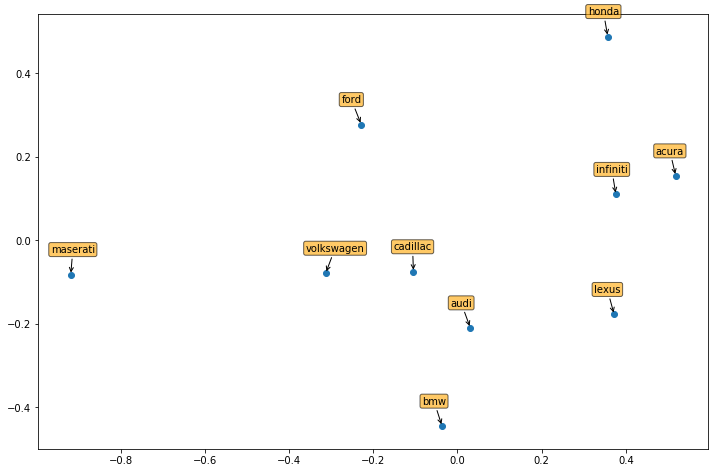

In [22]:
plot_mds(xdf,top_brands.word)

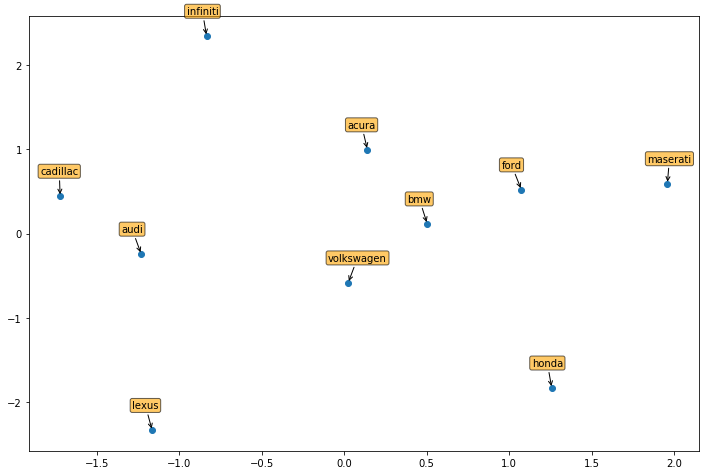

In [23]:
plot_mds(xdf,top_brands.word,1)

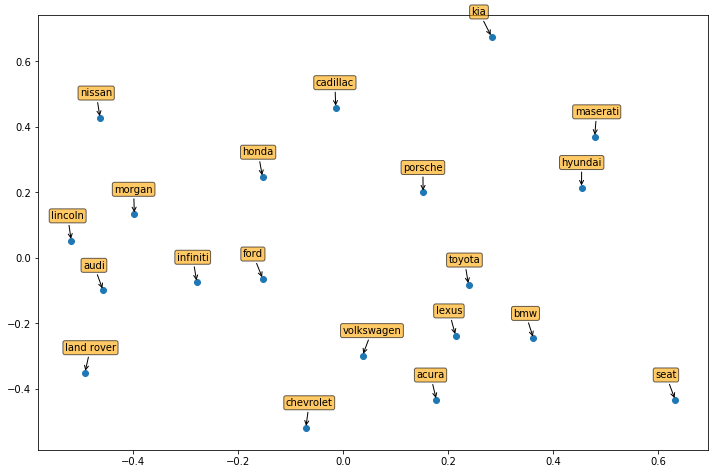

In [24]:
# plot MDS top 20
num_brands = 20
top_brands = rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(num_brands,'frequency')
lift_score = [get_lift(x,y,df.post_cunique) for x in top_brands.word for y in top_brands.word] #if x!=y]
xdf = reshape(lift_score,(num_brands,num_brands))
plot_mds(xdf,top_brands.word)

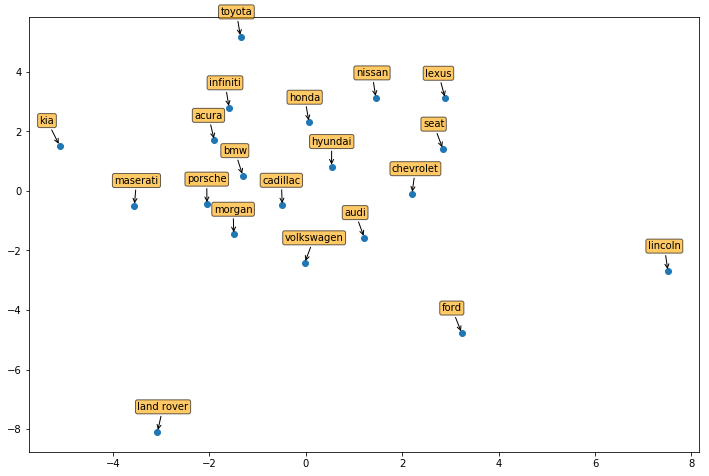

In [25]:
plot_mds(xdf,top_brands.word,1)

## What insights can you offer brand managers from your analysis in Task A (choose two brands that you can offer the most interesting/useful insights for)? 

### Frequently mentioned attributes for cars

For ientifying the top product attributes, we used the TF-IDF matrix and picked up the top 3 meaningful words (highest TF-IDF score) from every post. Detailed code in:https://github.com/abhinaya08/text_analytics/blob/master/assignment2/Product_Attribute_Recognition.ipynb

<br> We also manually scrubbed the top words based on frequency distribution : https://github.com/abhinaya08/text_analytics/blob/master/assignment2/most%20common%202k.csv

Following is the list of attributes that people are talking about and their categories:
1. Price
2. Comfort / interiors
3. Performance
4. Transmission
5. Wheel drive
6. Advanced Technological Features - WiFi, High end stereo system, multimedia interface
7. Car related features - mirrior, reverse, tyres, bumper, screen etc

### Now pick the 5 most frequently mentioned brands. Which attributes are most strongly associated with which of these 5 brands? 

#### We have picked the top 5 brands and replaced words with similar meaning to identify lift

In [26]:
# creating a dictionary for synonyms of product attributes based on most frequent words
prod_attributes = {'performance':['engine', 'engines', 'power', 'acceleration', 'quality', 'sport', 'mileage', 'torque', 'suspension', 'speed', 'sports',
                                  'weight', 'suspension','hp','efficiency','fuel'],
                   'transmission':['manual', 'auto', 'automatic', 'automatics', 'transmission','dsg'],
                   'wd':['awd', 'rwd', 'fwd', 'wheel', 'wheels','tires','steering','nif','clutch'],
                   'comfort':['class','interior','leather','brand','premium','seat','seats','experience',
                              'comfort','lux','comfortable','cushion'],
                   'price':['cheap', 'cheaper', 'costs', 'cost', 'economy', 'value',
                            '50k','45k','15k','35k','5k','10k','discount','credit'],
                  }

In [27]:
def getKeysByValue(dictOfElements, valueToFind):
    for k,v  in dictOfElements.items():
        if valueToFind in v:
            return(k)
    return  valueToFind

def replace_attributes(s):
    return([getKeysByValue(prod_attributes,y) for y in s])

In [28]:
#replacing product attributes which are synonyms
df["post_attributes"] = df.post_cunique.map(replace_attributes)

In [29]:
num_brands = 10
top_brands = rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(num_brands,'frequency')
product_list = prod_attributes.keys()
lift_score = [get_lift(x,y,df.post_attributes) for x in top_brands.word for y in product_list]
formatted_lift_score = [ round(elem,2) for elem in lift_score ]
#round(lift_score,2)

In [30]:
pd.DataFrame(reshape(formatted_lift_score,(num_brands,len(product_list))),index =top_brands.word , columns = product_list )

performance  transmission    wd  comfort  price
word                                                       
bmw                1.62          1.59  1.00     1.60   1.68
acura              1.38          1.48  1.95     1.51   1.29
audi               1.57          1.72  1.64     2.17   1.73
volkswagen         1.56          1.65  1.48     1.73   1.38
infiniti           1.20          1.45  1.92     1.57   1.50
honda              1.09          1.31  2.17     1.34   1.27
ford               1.39          1.48  1.06     1.80   1.52
cadillac           1.51          1.39  1.04     2.32   1.60
lexus              1.61          1.97  1.33     2.36   1.84
maserati           0.91          0.78  0.52     1.16   0.90

### While BMW has claimed that they are the “ultimate driving machine”, is that how people feel on Edmunds? Show your analysis.   

In [31]:
num_brands = 10
top_brands = rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(num_brands,'frequency')
product_list = ['ultimate','driving','machine']
lift_score = [get_lift(x,y,df.post_attributes) for x in top_brands.word for y in product_list]

In [32]:
formatted_lift_score = [round(elem,2) for elem in lift_score ]
pd.DataFrame(reshape(formatted_lift_score,(num_brands,len(product_list))),index =top_brands.word , columns = product_list )

ultimate  driving  machine
word                                  
bmw             2.70     1.82     2.08
acura           0.53     1.45     0.98
audi            1.45     1.97     1.32
volkswagen      1.10     1.79     0.98
infiniti        1.48     1.39     1.64
honda           0.81     1.47     0.38
ford            1.46     1.80     1.54
cadillac        3.65     1.70     3.09
lexus           3.08     1.99     2.21
maserati        1.46     0.75     0.29

In [33]:
# computing average
pd.DataFrame(reshape(formatted_lift_score,(num_brands,len(product_list))),index =top_brands.word , columns = product_list ).mean(axis=1)

word
bmw           2.200000
acura         0.986667
audi          1.580000
volkswagen    1.290000
infiniti      1.503333
honda         0.886667
ford          1.600000
cadillac      2.813333
lexus         2.426667
maserati      0.833333
dtype: float64

#### Checking for "ultimate driving machine" as trigram

In [34]:
#checking with trigrams
from nltk import ngrams
n=3
df["post_trigrams"] = df.post_cunique.map(lambda x: [grams for grams in ngrams(x, n)])

C:\Users\abhin\Anaconda2\envs\Python3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: generator 'ngrams' raised StopIteration
  after removing the cwd from sys.path.


In [35]:
trigrams = df["post_trigrams"].sum()

In [36]:
trigrams_words = nltk.FreqDist(trigrams)

#### "Ultimate driving machine" doesnt exist like a trigram. However, we have some interesting insights from the top 20 trigrams

In [37]:
trigrams_words.most_common(20)

[(('2001', '2015', '2017'), 397),
 (('2015', '2017', 'awd'), 397),
 (('2017', 'awd', 'honda'), 397),
 (('awd', 'honda', 'infiniti'), 397),
 (('honda', 'infiniti', 'sh'), 397),
 (('infiniti', 'sh', 'touring'), 397),
 (('sh', 'touring', 'type'), 397),
 (('2018', '430i', 'gran'), 311),
 (('430i', 'gran', 'maserati'), 311),
 (('2018', 'acura', 'aspec'), 306),
 (('acura', 'aspec', 'awd'), 306),
 (('aspec', 'awd', 'sh'), 306),
 (('1', '16', '17'), 177),
 (('16', '17', '4'), 177),
 (('17', '4', '6t'), 177),
 (('4', '6t', 'alltrack'), 177),
 (('6t', 'alltrack', 'audi'), 177),
 (('alltrack', 'audi', 'awd'), 177),
 (('audi', 'awd', 'commuter'), 177),
 (('awd', 'commuter', 'fwd'), 177)]

Honda and infiniti are often compared with 'awd' and 'fwd' (wheeel drives). We can observe this in our product attribute lift chart too

### Comparing brands across - ultimate driving machine

In [38]:
def get_conditional_lift(a,b,c,tokenized_data):
    p_ac = len([i for i in tokenized_data if a in i if c in i])
    p_bc = len([i for i in tokenized_data if c in i if b in i])
    p_c = len([i for i in tokenized_data if c in i])
    p_abc = len([i for i in tokenized_data if a in i if b in i if c in i])
    return float((p_abc * p_c)/(p_ac*p_bc))

In [39]:
top_brands = ['bmw','lexus','honda','infiniti','cadillac','audi']
product_list = ['ultimate','driving','machine']
conditional_lift = [get_conditional_lift(x,y,z,df.post_attributes) 
                    for x in top_brands for y in top_brands for z in product_list 
                    if x!=y]

In [40]:
formatted_lift_score = [round(elem,2) for elem in conditional_lift ]
index_list = [(x,y) for x in top_brands for y in top_brands if x!=y] 
pd.DataFrame(reshape(formatted_lift_score,(len(index_list),len(product_list))), index = index_list,columns = product_list)

ultimate  driving  machine
(bmw, lexus)              1.33     1.47     1.21
(bmw, honda)              1.33     0.99     1.15
(bmw, infiniti)           1.20     1.21     1.24
(bmw, cadillac)           1.33     1.42     1.39
(bmw, audi)               0.92     1.21     0.81
(lexus, bmw)              1.33     1.47     1.21
(lexus, honda)            2.04     1.20     4.73
(lexus, infiniti)         3.56     2.56     3.04
(lexus, cadillac)         1.82     1.59     1.42
(lexus, audi)             1.57     1.54     1.89
(honda, bmw)              1.33     0.99     1.15
(honda, lexus)            2.04     1.20     4.73
(honda, infiniti)         1.12     1.14     1.69
(honda, cadillac)         1.60     0.81     0.00
(honda, audi)             2.58     1.47     3.16
(infiniti, bmw)           1.20     1.21     1.24
(infiniti, lexus)         3.56     2.56     3.04
(infiniti, honda)         1.12     1.14     1.69
(infiniti, cadillac)      2.00     1.79     1.35
(infiniti, audi)          2.15     1.42     2.70
(cadillac, bmw)           1.33     1.42     1.39
(cadillac, lexus)         1.82     1.59     1.42
(cadillac, honda)         1.60     0.81     0.00
(cadillac, infiniti)      2.00     1.79     1.35
(cadillac, audi)          1.54     1.39     0.95
(audi, bmw)               0.92     1.21     0.81
(audi, lexus)             1.57     1.54     1.89
(audi, honda)             2.58     1.47     3.16
(audi, infiniti)          2.15     1.42     2.70
(audi, cadillac)          1.54     1.39     0.95

### Given a post talks about a certain brand, do reviewers talk about "ultimate driving machine"

In [41]:
top_brands = ['bmw','lexus','honda','infiniti','cadillac','audi']
product_list = ['ultimate','driving','machine']
conditional_lift = [get_conditional_lift(x,y,z,df.post_attributes) 
                    for x in product_list for y in product_list for z in top_brands 
                    if x!=y]

In [42]:
formatted_lift_score = [round(elem,2) for elem in conditional_lift]
index_list = [(x,y) for x in product_list for y in product_list if x!=y] 
pd.DataFrame(reshape(formatted_lift_score,(len(index_list),len(top_brands))), index = index_list,columns = top_brands)

bmw  lexus   honda  infiniti  cadillac   audi
(ultimate, driving)   5.36   3.52    5.24      5.56      5.92   3.00
(ultimate, machine)  46.55  36.36  184.13     43.14     32.72  30.85
(driving, ultimate)   5.36   3.52    5.24      5.56      5.92   3.00
(driving, machine)    4.29   4.52    5.83      5.29      5.53   3.47
(machine, ultimate)  46.55  36.36  184.13     43.14     32.72  30.85
(machine, driving)    4.29   4.52    5.83      5.29      5.53   3.47

### Advice to (i) product manager, and (ii) marketing/advertising manager of these brands based on attribute relations

### Most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?

In [43]:
num_brands = 10
top_brands = rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(num_brands,'frequency')
product_list = ['hope','dream','desire','wish','aspire','pray','want']
lift_score = [get_lift(x,y,df.post_attributes) for x in top_brands.word for y in product_list]

In [44]:
#checking average scores per brand
formatted_lift_score = [round(elem,2) for elem in lift_score ]
asp_df = pd.DataFrame(reshape(formatted_lift_score,(num_brands,len(product_list)))
                      ,index =top_brands.word 
                      , columns = product_list)
asp_df

hope  dream  desire  wish  aspire  pray  want
word                                                     
bmw         1.56   2.00    1.32  2.09    1.13  2.06  1.76
acura       1.61   0.83    1.12  0.70    0.62  0.00  1.25
audi        1.77   3.83    2.30  1.70    2.74  1.79  1.98
volkswagen  1.98   1.71    1.10  1.49    1.92  1.10  1.61
infiniti    1.72   1.85    1.02  0.97    0.52  0.00  1.53
honda       1.56   3.03    0.93  1.06    1.70  0.00  1.35
ford        2.27   3.79    0.83  1.69    3.41  0.00  2.03
cadillac    2.66   4.06    0.60  2.38    0.00  0.00  1.92
lexus       1.58   2.62    1.60  1.09    2.94  0.00  2.35
maserati    1.55   1.13    1.25  0.47    0.00  2.92  1.03

In [45]:
#Taking an average
asp_df.mean(axis=1)

word
bmw           1.702857
acura         0.875714
audi          2.301429
volkswagen    1.558571
infiniti      1.087143
honda         1.375714
ford          2.002857
cadillac      1.660000
lexus         1.740000
maserati      1.192857
dtype: float64

### Aspirational brand comment